In [1]:
import sys
import os
import random
import torch
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import pandas as pd

sys.path.append('../')

from models.gtzan_dataset import get_data_loaders


from utils import load_sample, rms_normalizer, get_songlist, Loader
from utils_folder.visualization import plot_waveform, plot_spectrogram

from constants import CLASS_IDX_MAPPER

In [8]:
f = 400
2595*np.log10(1+f/700)

509.3846041485975

In [20]:
def get_stats(songlist_dict, rms_normalization=False, peak=False, tomel=False, clamp=False, norm1=False, norm2=False):

    stat_dict = {}
    for key in songlist_dict:
        #rms, mins, maxs, amplitude_ranges = get_genre_stats(songlist_dict[key], rms_normalization=rms_normalization, peak=peak)
        #stat_dict[key] = (rms, mins, maxs, amplitude_ranges)
        rms, mins, maxs = get_genre_stats(songlist_dict[key], rms_normalization=rms_normalization, peak=peak, tomel=tomel, clamp=clamp, norm1=norm1, norm2=norm2)
        stat_dict[key] = (rms, mins, maxs)

    return stat_dict

loader = Loader()
def get_genre_stats(paths_to_songs, loader=loader, rms_normalization=False, peak=False, tomel=False, clamp=False, norm1=False, norm2=False):

    amplitude_ranges, rms, mins, maxs = [], [], [], []
    samples = []
    #max_amp, min_amp, rms = 0, 0, 0
    for song in paths_to_songs:
        wav_sample, _ = librosa.load(song)

        if peak:
            wav_sample = peak_normalizer(wav_sample)

        if rms_normalization:
            wav_sample = rms_normalizer(torch.tensor(wav_sample)).numpy()

        if norm1:
            wav_sample = (wav_sample - wav_sample.min()) / (wav_sample.max() - wav_sample.min())


        if tomel: 
            data_sample = loader.transform_wav(torch.tensor(wav_sample), clamp=clamp).numpy()
        else:
            data_sample = wav_sample


        if norm2:
            data_sample = (data_sample - data_sample.min()) / (data_sample.max() - data_sample.min())

        #if not peak and not rms_normalization:
        #    wav_sample = (wav_sample - torch.min(wav_sample)) / (torch.max(wav_sample) - torch.min(wav_sample))

        #min_amp = torch.min(wav_sample) if torch.min(wav_sample) < min_amp else min_amp
        #max_amp = torch.max(wav_sample) if torch.max(wav_sample) > max_amp else max_amp

        #r = torch.max(wav_sample) - torch.min(wav_sample)
        #rms += get_rms(wav_sample)

        #samples.append(wav_sample.numpy())

        rms.append(get_rms(data_sample))
        mins.append(np.min(data_sample))
        maxs.append(np.max(data_sample))
        #amplitude_ranges.append(torch.max(wav_sample) - torch.min(wav_sample))
    
    return rms, np.mean(np.stack(mins)), np.mean(np.stack(maxs))

    #return [float(min_amp), float(max_amp), float(rms / len(paths_to_songs))], wav_sample
    #return (float(rms / len(paths_to_songs)), amplitude_ranges)
    return rms, mins, maxs, amplitude_ranges

def st(amplitudes):
    stats_data = []
    all_amplitudes = np.concatenate(amplitudes)
    min_val, max_val = np.min(all_amplitudes), np.max(all_amplitudes)
    q1, median, q3 = np.percentile(all_amplitudes, [25, 50, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = all_amplitudes[(all_amplitudes < lower_bound) | (all_amplitudes > upper_bound)]
    
    stats_data.append({
        'Min': min_val,
        'Max': max_val,
        'Q1': q1,
        'Median': median,
        'Q3': q3,
        'Outliers': outliers
    })


    return stats_data

def get_rms(sig):
    return np.sqrt(np.mean(np.power(sig, 2)))


def peak_normalizer(sig):
    return sig / np.max(np.abs(sig))


def range_barplot(wav_stats):
    # Setting up the figure and axis
    fig = plt.figure(figsize=(10, 6))

    # Plotting the min and max values as bars
    for i, genre in enumerate(wav_stats.keys()):
        plt.bar(i, [abs(wav_stats[genre][0]), wav_stats[genre][1]])
        plt.scatter(i, wav_stats[genre][2], marker='D', color='black', label='RMS') if i==0 else plt.scatter(i, wav_stats[genre][2], marker='D', color='black')

    # Adding labels and title
    plt.xticks(np.arange(len(wav_stats.keys())), wav_stats.keys())
    plt.xlabel('Genre')
    plt.ylabel('Absolute Amplitude Range')
    plt.title('Amplitude Range and RMS Value per Genre')
    plt.legend()
    plt.show()
    

def print_signal_stats(name, sig):
    print(f'{name}:')
    print('Min: %5.3f, Max: %5.3f, RMS: %5.3f' % (torch.min(sig), torch.max(sig), get_rms(sig)))
    print('-'*10)


def plot_stats(data):
    df = pd.DataFrame(data)

    # Start plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns for two plots

    # RMS Boxplot
    axs[0].boxplot([df[cls][0] for cls in df.keys()], labels=df.keys())
    axs[0].set_title('RMS Distribution by Class')
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('RMS')

    # Amplitude Range Boxplot
    #axs[1].boxplot([df[cls][2] for cls in df.keys()], labels=df.keys())
    # Plotting bars directly from mean min to mean max

    abs_max = 0
    for i, key in enumerate(df.keys()):
        values = df[key]
        axs[1].bar(i, values[2] - values[1], bottom=values[1], edgecolor='black', width=0.6) #, color='turquoise'

        if np.abs(values[1]) > abs_max: abs_max = np.abs(values[1])
        if np.abs(values[2]) > abs_max: abs_max = np.abs(values[2])

    axs[1].set_xticks(np.arange(len(df.keys())))
    axs[1].set_xticklabels(df.keys())
    axs[1].set_title('Mean Amplitude Range per Class')
    axs[1].set_xlabel('Class')
    axs[1].set_ylabel('Amplitude Range')
    axs[1].set_ylim([-abs_max-0.1*abs_max,abs_max+0.1*abs_max])

    plt.tight_layout()
    plt.show()


In [3]:
path = '/Users/samuelharck/Desktop/masterthesis/data'

songlist_dict = get_songlist(path)


#wav_stats_normalized_by_rms, wav_rms = get_stats(songlist_dict, rms_normalization=True)
#wav_stats_normalized_by_peak, wav_peak = get_stats(songlist_dict, peak=True)
#wav_stats_normalized_by_both, wav_both = get_stats(songlist_dict, rms_normalization=True, peak=True)

## Dataset as is

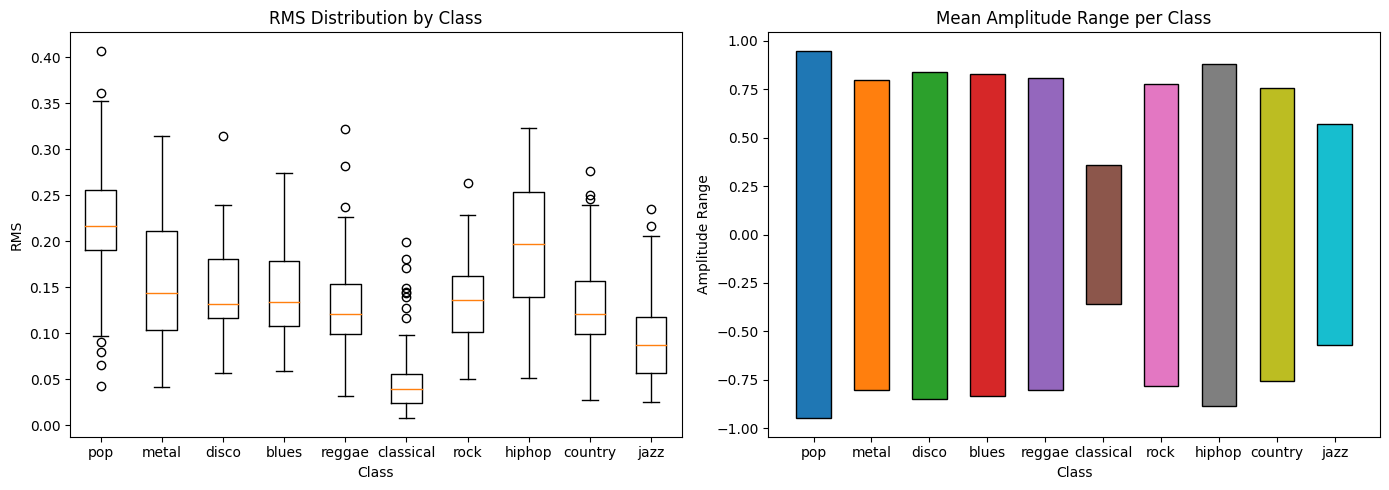

In [4]:
data = get_stats(songlist_dict)
plot_stats(data)

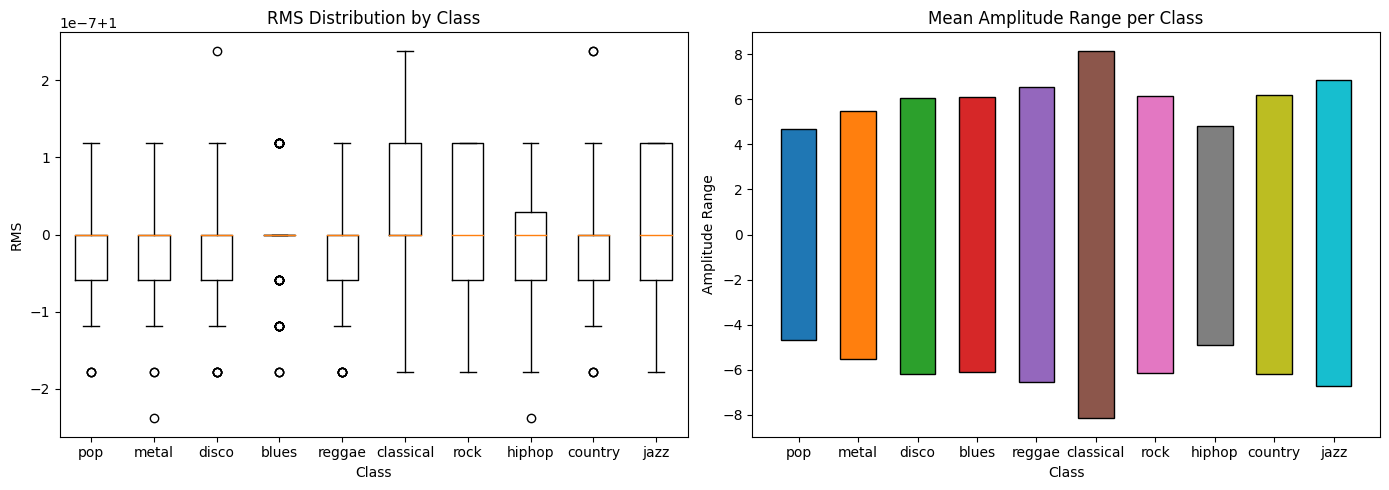

In [68]:
data = get_stats(songlist_dict, rms_normalization=True)
plot_stats(data)

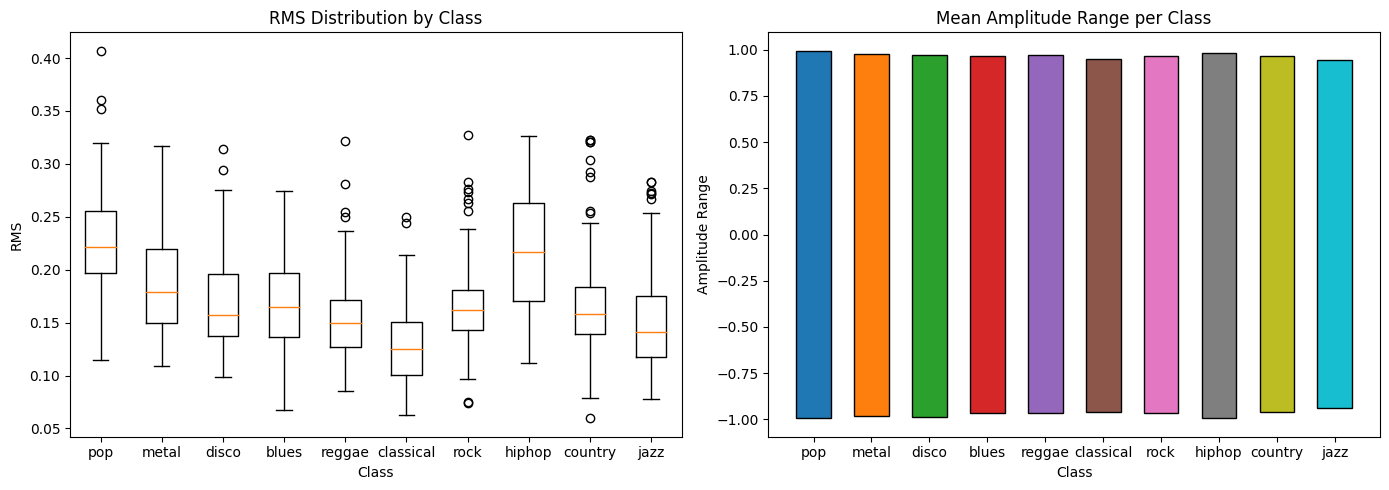

In [6]:
data = get_stats(songlist_dict, peak=True)
plot_stats(data)

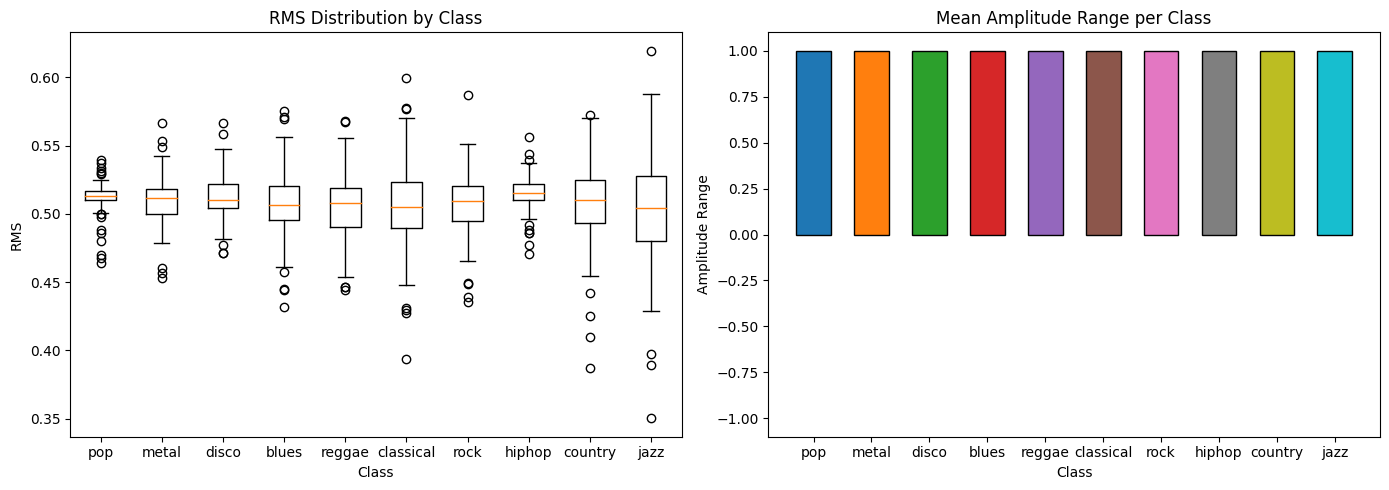

In [7]:
data = get_stats(songlist_dict, norm=True)
plot_stats(data)

# Pipeline mel plots
- before and after clamp 
- before and after normalization

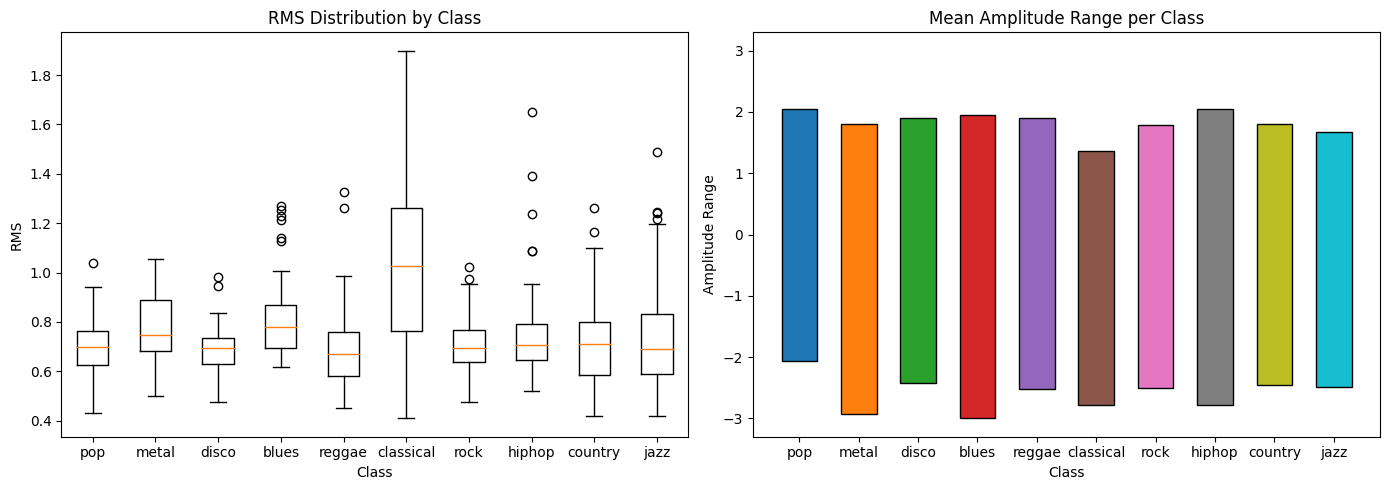

In [9]:
from drsa.preprocessing import get_songs_new

data = get_stats(songlist_dict, tomel=True)
plot_stats(data)

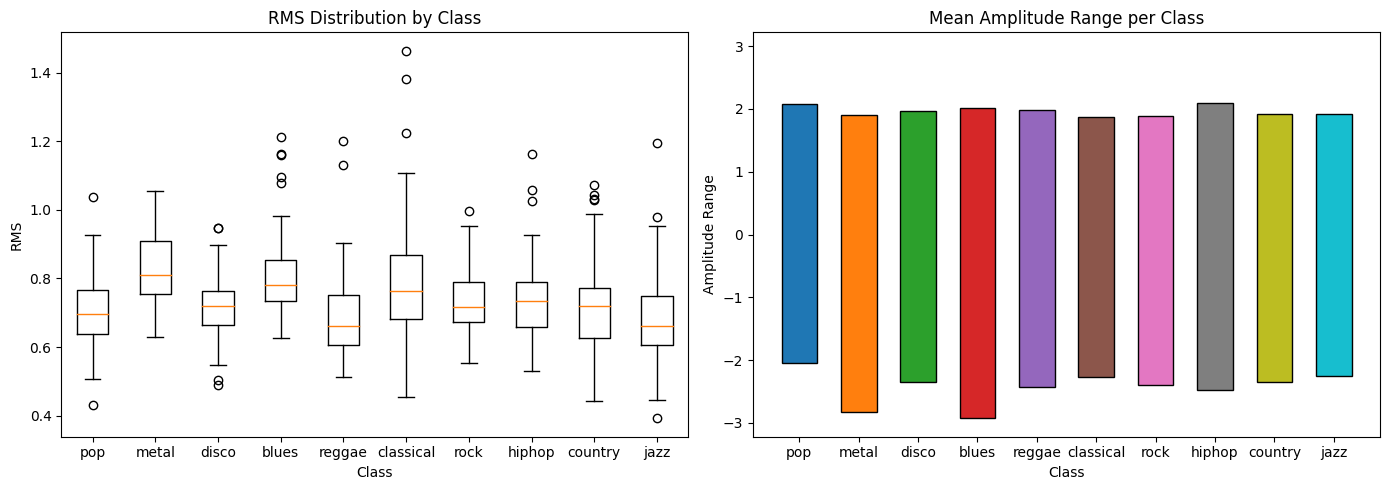

In [23]:
data = get_stats(songlist_dict, peak=True, tomel=True, clamp=True)
plot_stats(data)

data = get_stats(songlist_dict, norm1=True, tomel=True)
plot_stats(data)

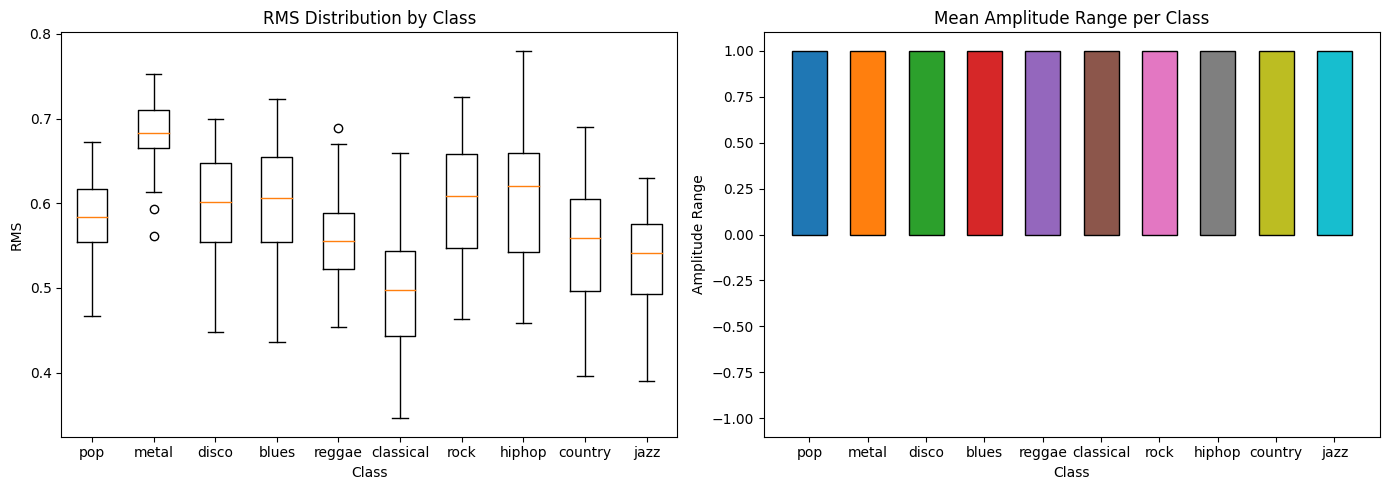

In [22]:
data = get_stats(songlist_dict, norm1=True, norm2=True, tomel=True)
plot_stats(data)

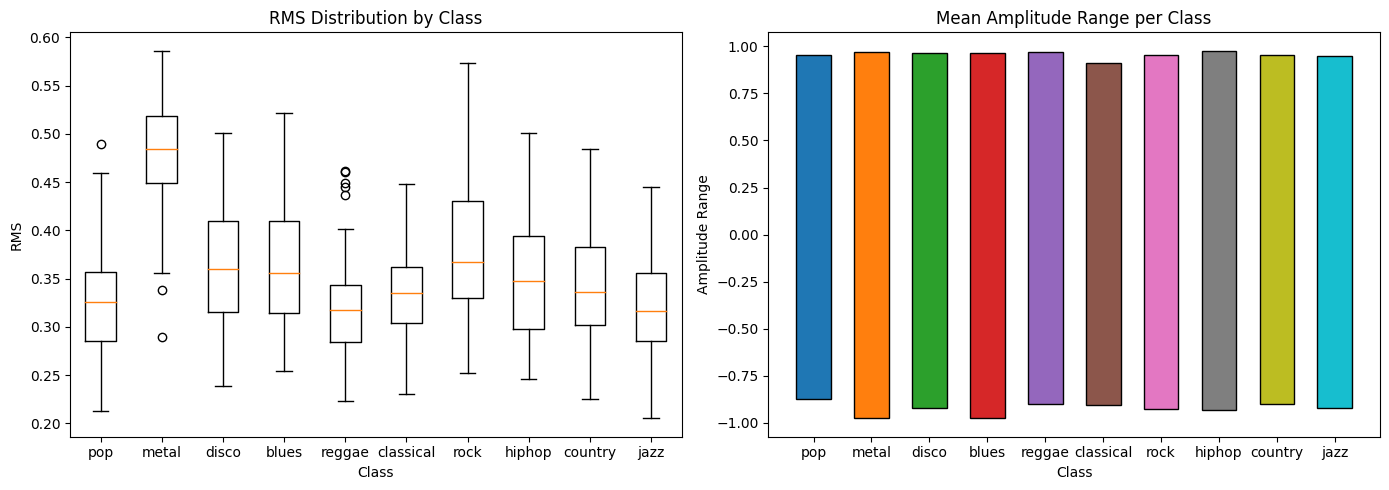

In [15]:
data = get_stats(songlist_dict, tomel=True, clamp=True, norm=True)
plot_stats(data)

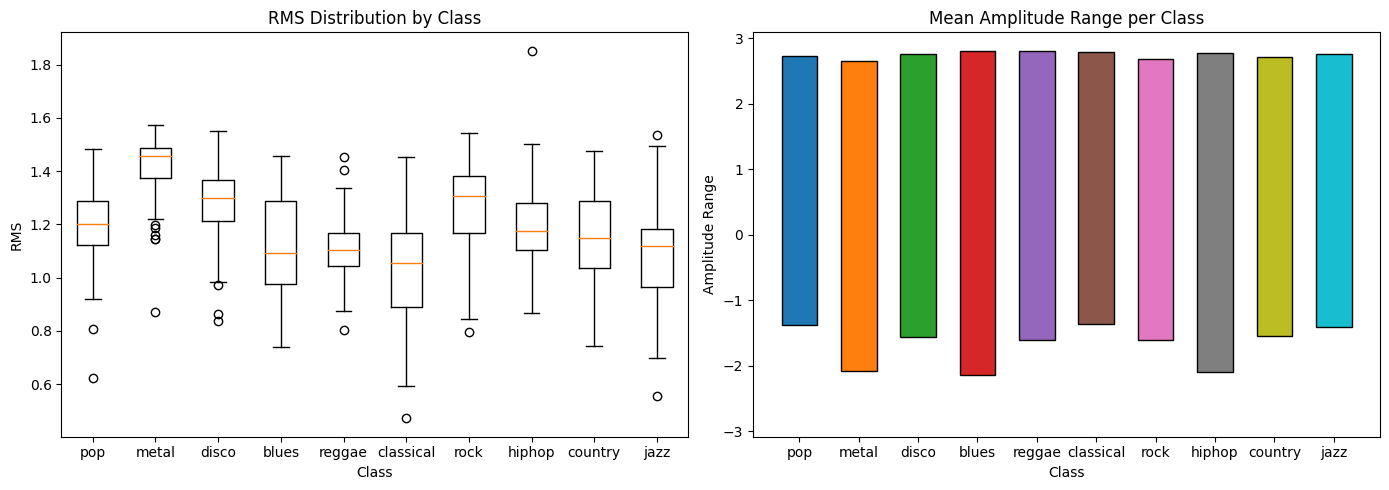

In [12]:
data = get_stats(songlist_dict, rms_normalization=True, tomel=True)
plot_stats(data)

# With mel-normalization, audio norm has no effect on the outcome

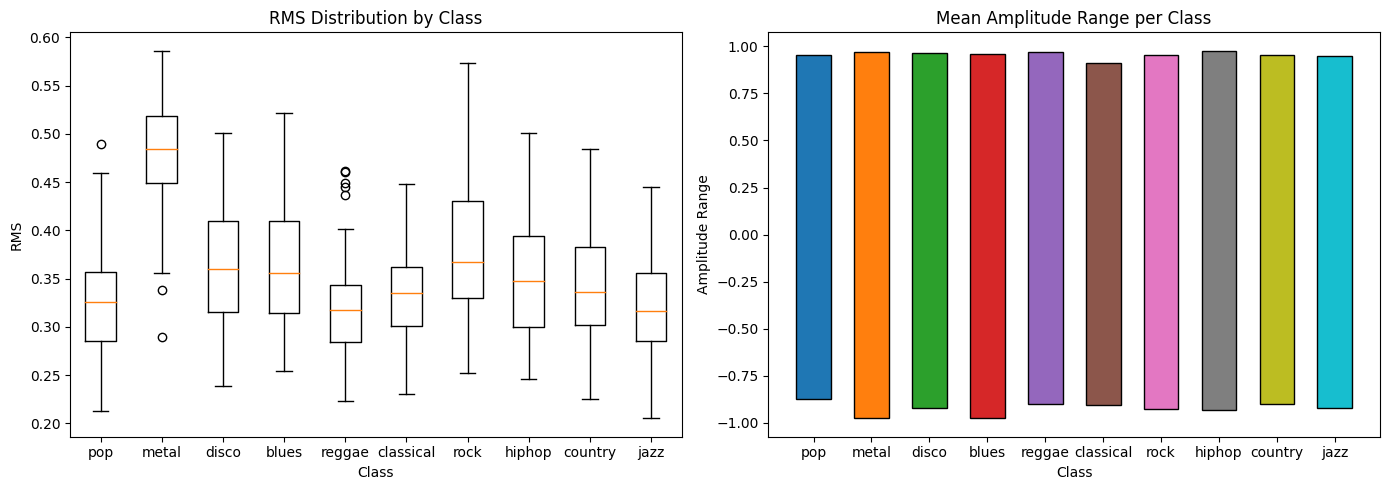

In [13]:
data = get_stats(songlist_dict, tomel=True, clamp=True, norm=True, peak=True)
plot_stats(data)

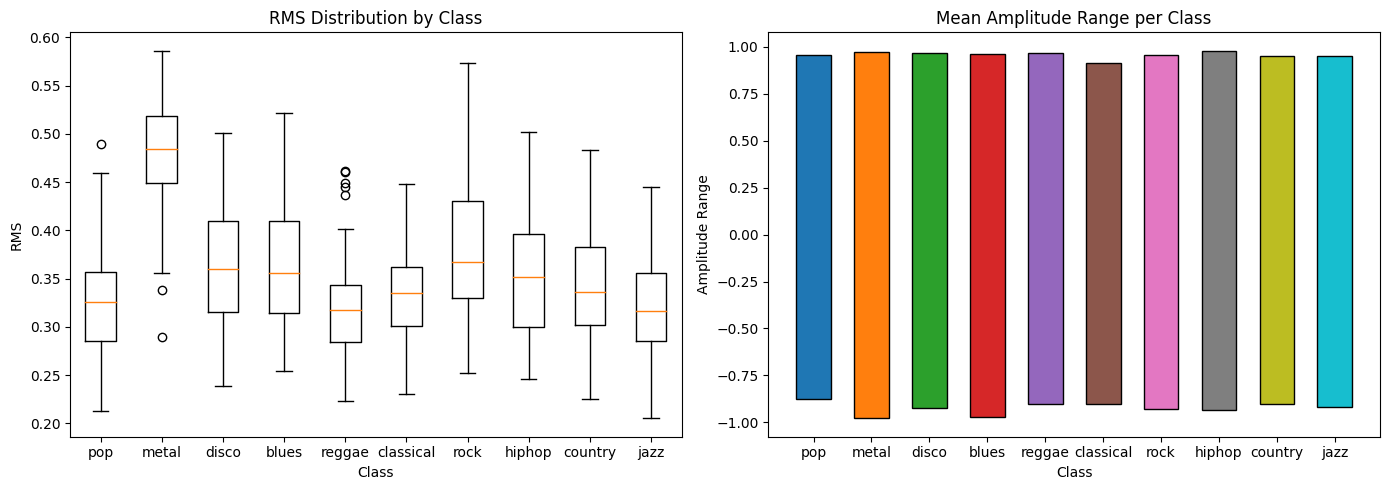

In [14]:
data = get_stats(songlist_dict, tomel=True, clamp=True, norm=True, rms_normalization=True)
plot_stats(data)

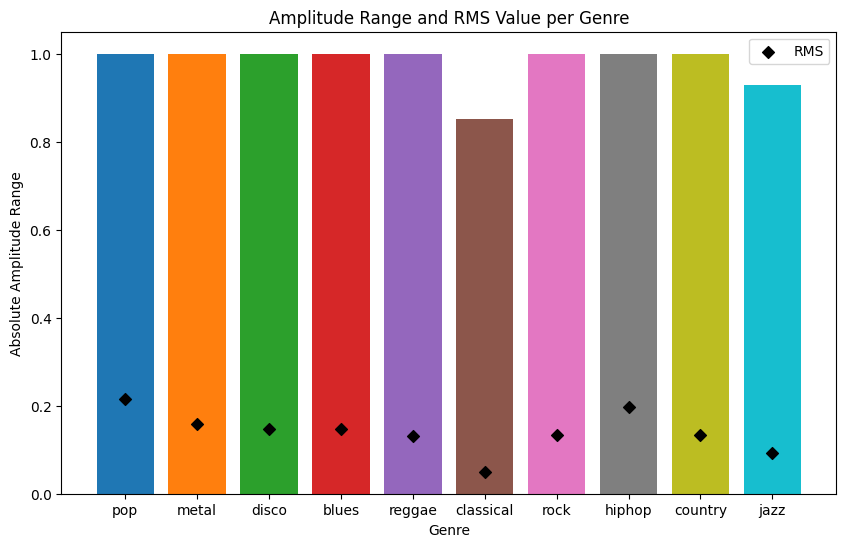

In [8]:
range_barplot(wav_stats)
Audio(wav_norm.numpy(), rate=22050)

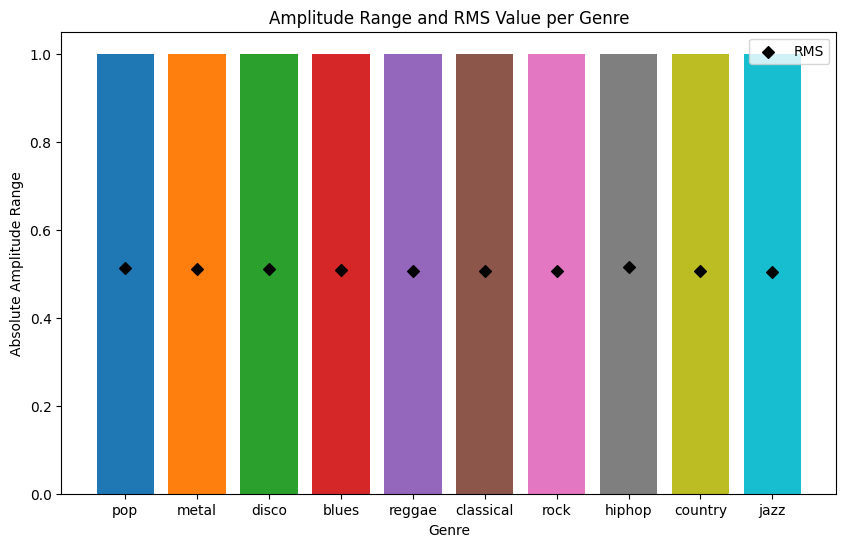

In [81]:
range_barplot(wav_stats)
Audio(wav_norm.numpy(), rate=22050)

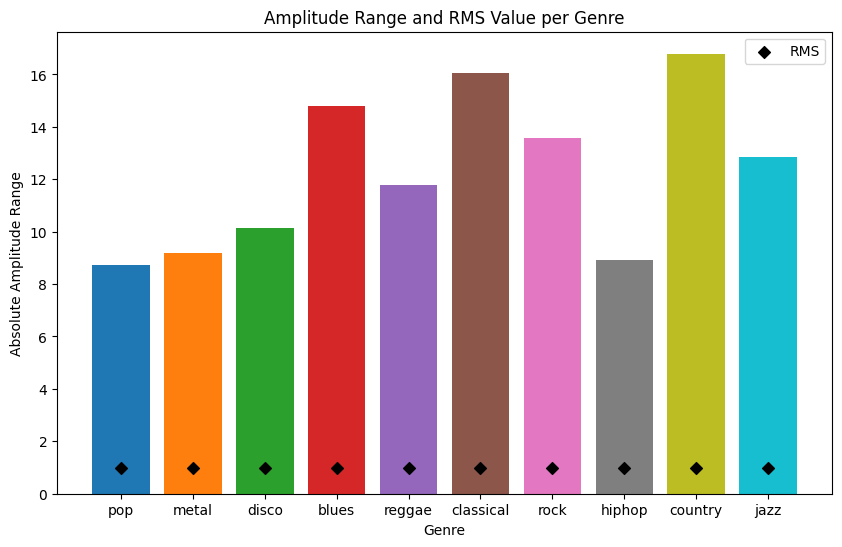

In [78]:
range_barplot(wav_stats_normalized_by_rms)
Audio(wav_rms.numpy(), rate=22050)

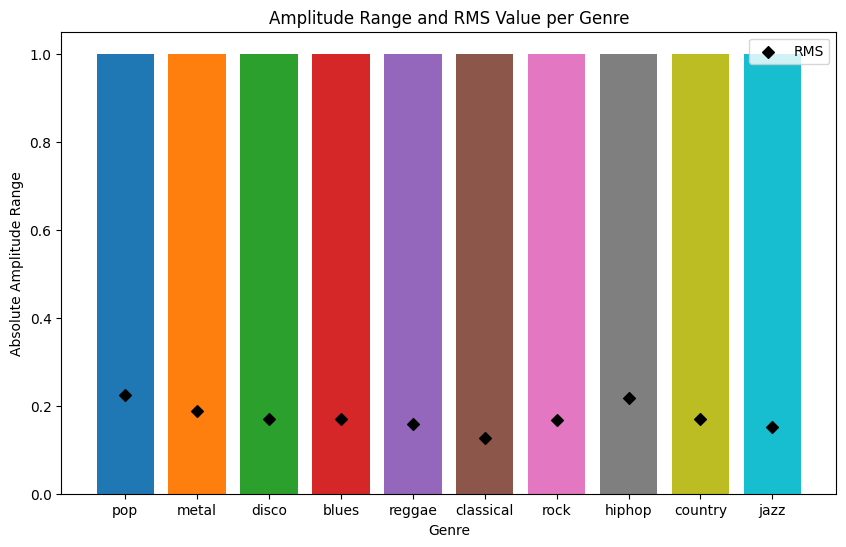

In [16]:
range_barplot(wav_stats_normalized_by_peak)
Audio(wav_peak.numpy(), rate=22050)

## Mels

In [89]:
t = torch.tensor([1,2,3]).to('cpu')

In [91]:
t.device == torch.device('cpu')

True

In [84]:
def get_mel_stats(songlist_dict, normalize_mel=True, norm='rms'):
    mel_stats = {}

    for key in songlist_dict:
        rms = 0
        min_amp = 0
        max_amp = 0
        for path_to_audio in songlist_dict[key]:

            mel_sample, _ = load_sample(path_to_audio, slice_length=6, num_chunks=4, to_mel=True, normalize=normalize_mel, case='128_256', audio_normalization=norm)
            mel_sample = normalize(mel_sample) if normalize_mel else mel_sample
            rms += get_rms(mel_sample)
            min_amp = torch.min(mel_sample) if torch.min(mel_sample) < min_amp else min_amp
            max_amp = torch.max(mel_sample) if torch.max(mel_sample) > max_amp else max_amp

        mel_stats[key] = [min_amp, max_amp, rms / len(songlist_dict[key])]
    
    return mel_stats

def normalize(mel):
    if mel.size(0) > 1:
        mel = (mel - torch.min(torch.min(mel, -1, keepdim=True)[0], -2, keepdim=True)[0]) / \
            (torch.max(torch.max(mel, -1, keepdim=True)[0], -2, keepdim=True)[0] - torch.min(torch.min(mel, -1, keepdim=True)[0], -2, keepdim=True)[0])
    else:
        mel = (mel - torch.min(mel)) / (torch.max(mel) - torch.min(mel))
    return mel

## No audio normalization

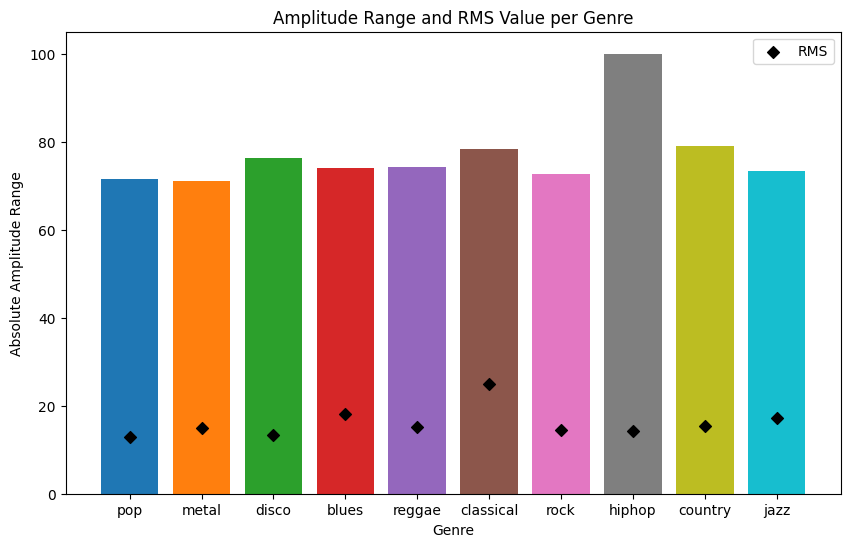

In [85]:
mel_stats = get_mel_stats(songlist_dict, normalize_mel=False, norm=None)
range_barplot(mel_stats)
#Audio(wav_norm.numpy(), rate=22050)

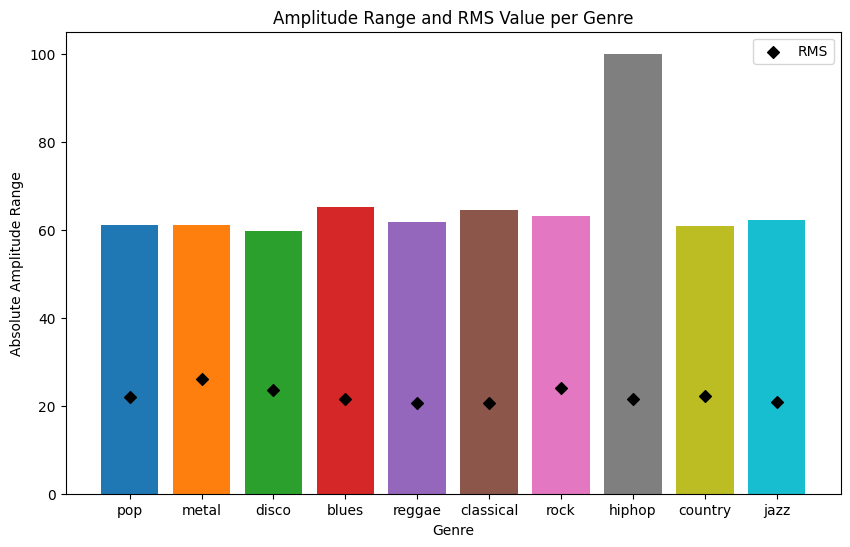

In [86]:
mel_stats = get_mel_stats(songlist_dict, normalize_mel=False, norm='rms')
range_barplot(mel_stats)
#Audio(wav_norm.numpy(), rate=22050)

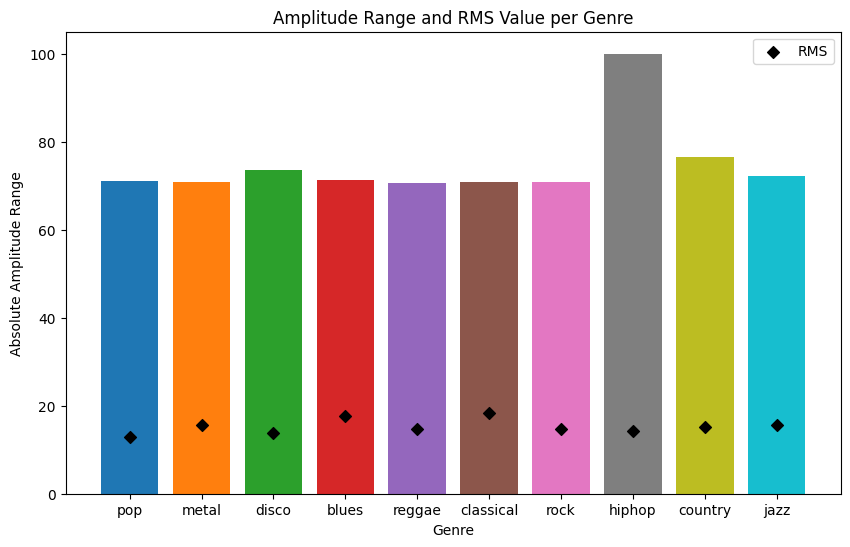

In [87]:
mel_stats = get_mel_stats(songlist_dict, normalize_mel=False, norm='peak')
range_barplot(mel_stats)
#Audio(wav_norm.numpy(), rate=22050)

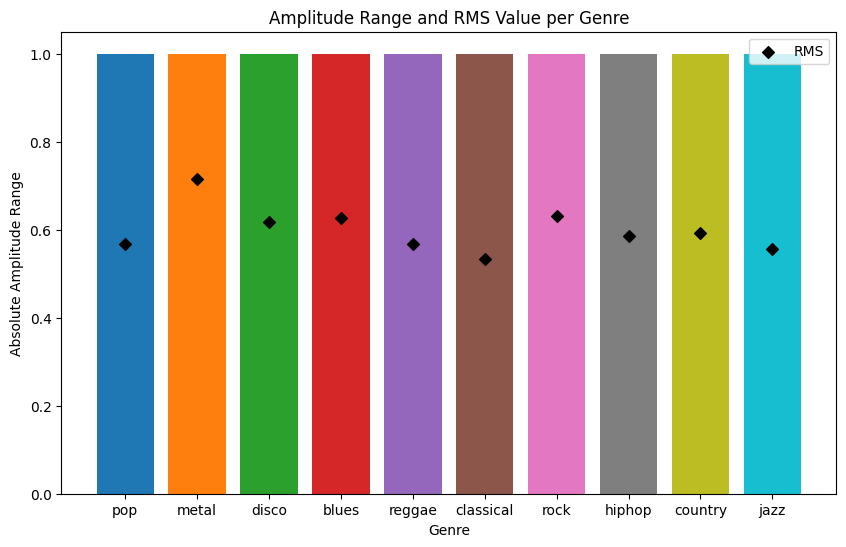

In [88]:
mel_stats = get_mel_stats(songlist_dict, normalize_mel=True, norm=None)
range_barplot(mel_stats)
#Audio(wav_norm.numpy(), rate=22050)

In [7]:
mel_stats

{'pop': [tensor(-4.6634), tensor(3.0479), tensor(0.7988)],
 'metal': [tensor(-4.6648), tensor(2.7384), tensor(0.9392)],
 'disco': [tensor(-4.7978), tensor(2.8463), tensor(0.8487)],
 'blues': [tensor(-5.1033), tensor(2.8380), tensor(1.1672)],
 'reggae': [tensor(-4.8341), tensor(2.9324), tensor(0.9880)],
 'classical': [tensor(-5.4469), tensor(2.5522), tensor(1.6458)],
 'rock': [tensor(-4.7335), tensor(2.6930), tensor(0.9158)],
 'hiphop': [tensor(-6.4813), tensor(3.0171), tensor(0.8988)],
 'country': [tensor(-5.1338), tensor(2.6794), tensor(0.9926)],
 'jazz': [tensor(-4.7670), tensor(2.6201), tensor(1.1384)]}

### RMS

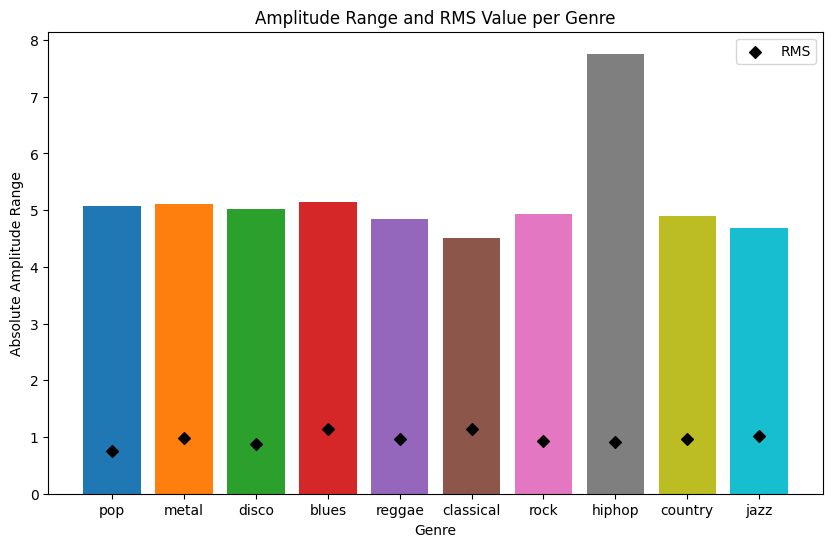

In [17]:
mel_stats = get_mel_stats(songlist_dict, norm='rms')
range_barplot(mel_stats)
#Audio(wav_norm.numpy(), rate=22050)

In [13]:
mel_stats

{'pop': [tensor(-5.0656), tensor(3.0769), tensor(0.7615)],
 'metal': [tensor(-5.1012), tensor(3.0157), tensor(0.9781)],
 'disco': [tensor(-5.0122), tensor(2.8712), tensor(0.8691)],
 'blues': [tensor(-5.1421), tensor(3.2403), tensor(1.1420)],
 'reggae': [tensor(-4.8349), tensor(3.0102), tensor(0.9579)],
 'classical': [tensor(-4.5108), tensor(3.1965), tensor(1.1410)],
 'rock': [tensor(-4.9357), tensor(3.0654), tensor(0.9346)],
 'hiphop': [tensor(-7.7576), tensor(3.0354), tensor(0.9102)],
 'country': [tensor(-4.9030), tensor(2.9525), tensor(0.9670)],
 'jazz': [tensor(-4.6886), tensor(3.0376), tensor(1.0135)]}

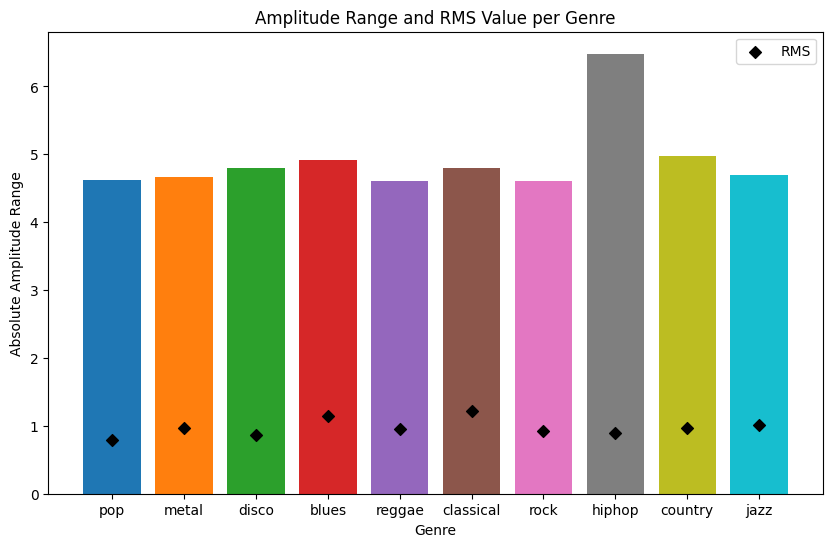

In [18]:
mel_stats_peak = get_mel_stats(songlist_dict, norm='peak')
range_barplot(mel_stats_peak)

In [8]:
mel_stats_peak

{'pop': [tensor(-4.6230), tensor(3.0479), tensor(0.7949)],
 'metal': [tensor(-4.6648), tensor(2.7384), tensor(0.9729)],
 'disco': [tensor(-4.7978), tensor(2.8463), tensor(0.8586)],
 'blues': [tensor(-4.9094), tensor(2.8647), tensor(1.1433)],
 'reggae': [tensor(-4.6114), tensor(2.9711), tensor(0.9526)],
 'classical': [tensor(-4.8020), tensor(2.8770), tensor(1.2247)],
 'rock': [tensor(-4.6080), tensor(2.7919), tensor(0.9227)],
 'hiphop': [tensor(-6.4813), tensor(3.0171), tensor(0.8990)],
 'country': [tensor(-4.9789), tensor(2.7668), tensor(0.9701)],
 'jazz': [tensor(-4.7016), tensor(2.7661), tensor(1.0172)]}